Script analyses hidden layer representation geometry

1. RDMs
2. MDS

In [209]:
import itertools
import copy
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import pickle
import random
from sklearn.model_selection import train_test_split
import time
from joblib import Parallel, delayed
import pandas as pd
import sys
import os
import seaborn as sns 
from sklearn.metrics import r2_score
import math
import matplotlib as mpl
from sklearn.manifold import MDS
from sklearn.metrics.pairwise import manhattan_distances, euclidean_distances
import scipy
from matplotlib.lines import Line2D
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from sklearn.decomposition import PCA
import statannot

from cryptic_rnn import *

In [210]:
## plotting
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [211]:
# RNN params
num_classes = 22
batchsize=1
hidden_size = 10

ops = '+'

num_inputs = 4
total_syms = ['A','B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P']
all_syms = total_syms[:num_inputs]
all_input_vals = list(np.arange(2,18))
input_vals = random.sample(all_input_vals,num_inputs)
# randomly select values for each input
cue_dict = {}
for i, s in enumerate(all_syms):
    cue_dict[s] = input_vals[i]
    
print('cue_dict ',cue_dict)
primitives = generate_pos_primitives(all_syms, cue_dict)
print('primitives ',primitives)

trainseqs = generate_pos_other(ops, all_syms, cue_dict)[:2]
trainseqs_b = trainseqs + generate_balanced_primitives(ops, all_syms, cue_dict)
trainseqs_p = trainseqs + primitives

print('trainseqs ',trainseqs)
print('trainseqs_b ',trainseqs_b)
print('trainseqs_p ',trainseqs_p)

testseqs_all = generate_pos_trials(ops, all_syms, all_syms, cue_dict)
testseqs = [seq for seq in testseqs_all if seq not in trainseqs_b]
valset_idx = [idx for idx, seq in enumerate(testseqs_all) if seq not in trainseqs_b]

print('testseqs ', testseqs )

cue_dict  {'A': 12, 'B': 2, 'C': 5, 'D': 8}
primitives  [[('+', 'A'), '=', 12], [('+', 'B'), '=', 2], [('+', 'C'), '=', 5], [('+', 'D'), '=', 8]]
trainseqs  [[('+', 'A'), ('+', 'B'), '=', 14], [('+', 'B'), ('+', 'C'), '=', 7]]
trainseqs_b  [[('+', 'A'), ('+', 'B'), '=', 14], [('+', 'B'), ('+', 'C'), '=', 7], [('+', 'A'), ('+', 'C'), '=', 17], [('+', 'B'), ('+', 'D'), '=', 10]]
trainseqs_p  [[('+', 'A'), ('+', 'B'), '=', 14], [('+', 'B'), ('+', 'C'), '=', 7], [('+', 'A'), '=', 12], [('+', 'B'), '=', 2], [('+', 'C'), '=', 5], [('+', 'D'), '=', 8]]
testseqs  [[('+', 'A'), ('+', 'A'), '=', 24], [('+', 'A'), ('+', 'D'), '=', 20], [('+', 'B'), ('+', 'A'), '=', 14], [('+', 'B'), ('+', 'B'), '=', 4], [('+', 'C'), ('+', 'A'), '=', 17], [('+', 'C'), ('+', 'B'), '=', 7], [('+', 'C'), ('+', 'C'), '=', 10], [('+', 'C'), ('+', 'D'), '=', 13], [('+', 'D'), ('+', 'A'), '=', 20], [('+', 'D'), ('+', 'B'), '=', 10], [('+', 'D'), ('+', 'C'), '=', 13], [('+', 'D'), ('+', 'D'), '=', 16]]


In [255]:
ca, cb, cc, cd = 'green', 'blue', 'orange', 'red'
colors1 = [ca]*4 + [cb]*4 + [cc]*4 + [ cd]*4 + [ca, cb, cc, cd]
colors2 = [ca, cb, cc, cd]*4 + ['black']*4

msize = 12
legend_elements = [Line2D([0], [0], marker=7, color='w', markerfacecolor =ca, markersize=msize, label=' + A _'),
                   Line2D([0], [0], marker=7, color='w', markerfacecolor =cb, markersize=msize, label=' + B _'), 
                   Line2D([0], [0], marker=7, color='w', markerfacecolor =cc, markersize=msize, label=' + C _'),
                   Line2D([0], [0], marker=7, color='w', markerfacecolor =cd, markersize=msize, label=' + D _'),
                   Line2D([0], [0], marker=6, color='w', markerfacecolor=ca, markersize=msize, label=' _ + A'),
                   Line2D([0], [0], marker=6, color='w', markerfacecolor=cb, markersize=msize, label=' _ + B'), 
                   Line2D([0], [0], marker=6, color='w', markerfacecolor=cc, markersize=msize, label=' _ + C'),
                   Line2D([0], [0], marker=6, color='w', markerfacecolor=cd, markersize=msize, label=' _ + D'),
                   ]

def MDS_plot(matlist, testseqs, trainseqs, MDStype = 'MDS', title = '', min_dim = 0, rand_state = 0, plotlines=False):
    
    valset = [t for t in testseqs if t not in trainseqs]
    valset_idx = [testseqs.index(val) for val in valset]
    
    plt.rcParams['figure.figsize'] = 9, 3
    fig, axs = plt.subplots(1,3)

    for j, dist in enumerate(matlist[1:]):
        if MDStype == 'PCA':
            mds = PCA(n_components=3)
        if MDStype == 'MDS':
            mds = MDS(dissimilarity='precomputed',random_state=rand_state, n_components=3)

        X_transform = mds.fit_transform(dist)
        ax = axs[j]
        ax.title.set_text('step: '+str(j+2))
        ax.set_xlabel('Dimension 1')
        if j == 0:
            ax.set_ylabel('Dimension 2')
        else:
            ax.set_yticks([])
        
        for i in range(len(testseqs)):
            if i in valset_idx:
                alph = 1
            else:
                alph = 0.2
            ax.scatter(X_transform[i,min_dim], X_transform[i,min_dim+1], marker=7, s=100, color = colors1[i], alpha = alph)
            ax.scatter(X_transform[i,min_dim], X_transform[i,min_dim+1], marker=6, s=100, color=colors2[i], alpha = alph)
            
        if plotlines:
            for k in range(4):
                ax.plot([X_transform[4*k,0], X_transform[4*k+3,0]], [X_transform[4*k,1], X_transform[4*k+3,1]], color = colors2[k])
                ax.plot([X_transform[k,0], X_transform[12+k,0]], [X_transform[k,1], X_transform[12 + k,1]], color = colors2[k])


    plt.suptitle('2D-'+MDStype+': '+title, y=1.05)
    fig.legend(handles=legend_elements,  loc='center left', bbox_to_anchor=(1, 0.5)) 

    
def MDS_plot_prims(meanRDM, testseqs, MDStype = 'MDS', title = '', min_dim = 0, step_num = 4, plotlines=True, rand_state = 0):
    
    plt.rcParams['figure.figsize'] = 6, 6
    fig, ax = plt.subplots()

    if MDStype == 'PCA':
        mds = PCA(n_components=3)
    if MDStype == 'MDS':
        mds = MDS(dissimilarity='precomputed',random_state=rand_state, n_components=3)

    X_transform = mds.fit_transform(meanRDM[0])
    ax.title.set_text('step: '+str(step_num))
    for i in range(16):
        ax.scatter(X_transform[i,min_dim], X_transform[i,min_dim+1], marker=7, color = colors1[i], s=180)
        ax.scatter(X_transform[i,min_dim], X_transform[i,min_dim+1], marker=6, color = colors2[i], s=180)
    for j in range(16,len(testseqs)):
        ax.plot([X_transform[j,min_dim]], [X_transform[j,min_dim+1]], marker=7, color=colors1[j], markersize = 16)
        ax.plot([X_transform[j,min_dim]], [X_transform[j,min_dim+1]], marker='_', color = colors2[j], markersize = 16,\
               markeredgewidth=3)
    if plotlines:
        for k in range(4):
            ax.plot([X_transform[4*k,0], X_transform[4*k+3,0]], [X_transform[4*k,1], X_transform[4*k+3,1]], color = colors2[k])
            ax.plot([X_transform[k,0], X_transform[12+k,0]], [X_transform[k,1], X_transform[12 + k,1]], color = colors2[k])

    ax.set_xlabel('Dimension 1')
    ax.set_ylabel('Dimension 2')
    plt.suptitle('2D-'+MDStype+': '+title)
    fig.legend(handles=legend_elements,  loc='center left', bbox_to_anchor=(1, 0.5)) 
 

# Read Data

In [213]:
savedir = '../results/train_2seqs/res_20'
with open(savedir, 'rb') as f:
    res2 = pickle.load(f)


In [214]:
full_rdmats = calculate_RDMs(res2, testseqs_all, hidden_size=20)
dms_p = full_rdmats['rdms_p']
dms_b = full_rdmats['rdms_b']
cue_dicts =  full_rdmats['cue_dicts']

matlist_p = [np.array(d).mean(axis = 0) for d in dms_p]
matlist_b = [np.array(d).mean(axis = 0) for d in dms_b]

# Averaged MDS

In [215]:
x=48

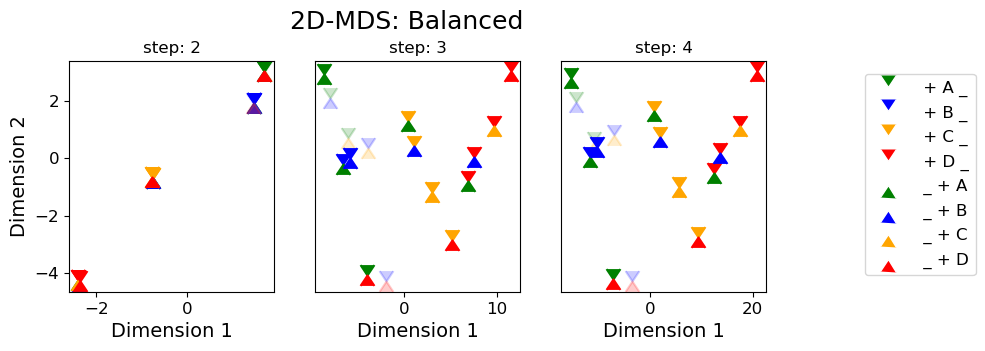

In [256]:
MDS_plot(matlist_b, testseqs_all, trainseqs_b, MDStype = 'MDS', title='Balanced', rand_state=x)

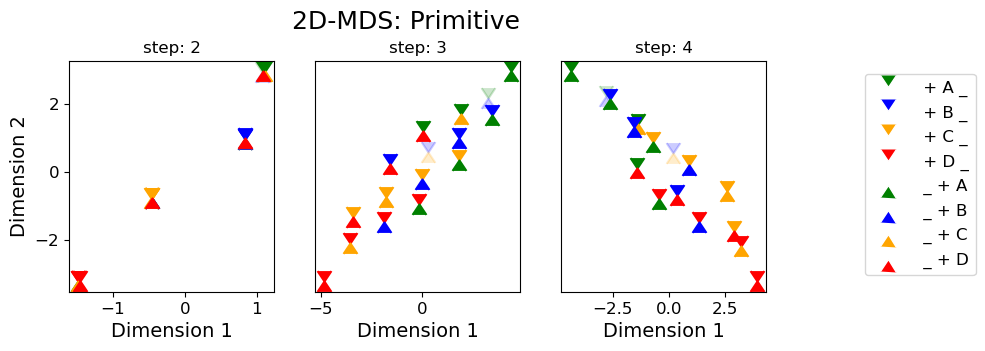

In [258]:
MDS_plot(matlist_p, testseqs_all, trainseqs_p, title='Primitive', rand_state=x)

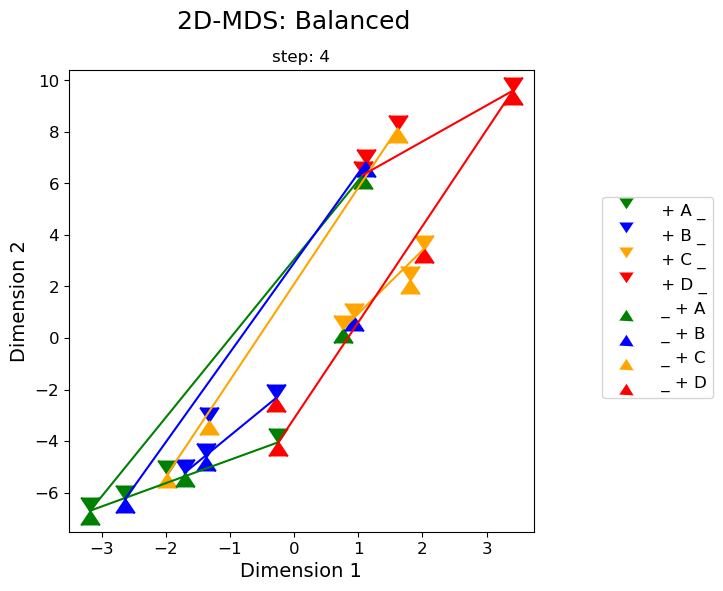

In [229]:
#MDS_plot_prims([matlist_b[2]], testseqs_all, rand_state=80, title='Balanced')
MDS_plot_prims([matlist_b[2]], testseqs_all, title='Balanced', rand_state=3)

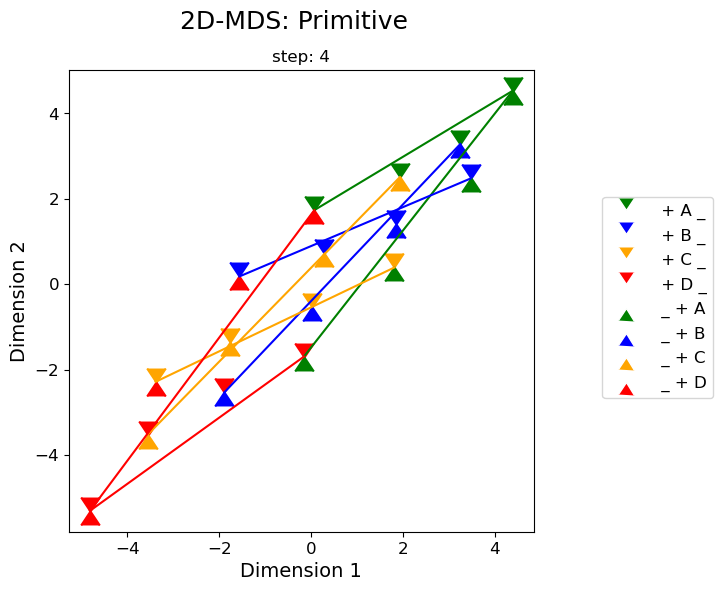

In [226]:
x=48
#MDS_plot_prims([matlist_p[2]], testseqs_all, rand_state=80, title='Primitives')
MDS_plot_prims([matlist_p[2]], testseqs_all, title='Primitive', rand_state=x, plotlines=True)

# Addend Augend clustering

In [232]:
## lazy regime
bp_pal = {'Balanced': '#00A7E1', 'Primitive':'#F17720'}


In [200]:
save_dir = '../results/train_2seqs/res_20_lazy'
with open(save_dir, 'rb') as f:
    resl = pickle.load(f)


In [201]:
hidden_size=20
full_rdmatsl = calculate_RDMs(resl, testseqs_all, hidden_size=20)
dms_pl = full_rdmatsl['rdms_p']
dms_bl = full_rdmatsl['rdms_b']
cue_dictsl =  full_rdmatsl['cue_dicts']


In [252]:
t=2
all_dists_p = []
for dm in dms_p[t]:
    dists = []
    for j in range(4):
        dists.append(dm[4*j,4*j+3]/dm[j, 12+j])
    
    all_dists_p.append(dists)

all_dists_b = []
for dm in dms_b[t]:
    dists = []
    for j in range(4):
        dists.append(dm[4*j,4*j+3]/dm[j, 12+j])
    all_dists_b.append(dists)

totdata = np.append(np.array(all_dists_b).flatten(), np.array(all_dists_p).flatten())
kind_data = np.repeat(['Balanced', 'Primitive'], len(np.array(all_dists_b).flatten()))
df = pd.DataFrame({'Distance':totdata, 'Curriculum':kind_data})

In [253]:
t=2

all_dists_pl = []
for dm in dms_pl[t]:
    dists = []
    for j in range(4):
        dists.append(dm[4*j,4*j+3]/dm[j, 12+j])
    
    all_dists_pl.append(dists)

all_dists_bl = []
for dm in dms_bl[t]:
    dists = []
    for j in range(4):
        dists.append(dm[4*j,4*j+3]/dm[j, 12+j])
    all_dists_bl.append(dists)

totdata = np.append(np.array(all_dists_bl).flatten(), np.array(all_dists_pl).flatten())
kind_data = np.repeat(['Balanced', 'Primitive'], len(np.array(all_dists_bl).flatten()))
dfl = pd.DataFrame({'Distance':totdata, 'Curriculum':kind_data})

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Using zero_method  wilcox
Balanced v.s. Primitive: Wilcoxon test (paired samples) with Bonferroni correction, P_val=0.000e+00 stat=3.800e+01


(<AxesSubplot: xlabel='Curriculum', ylabel='Addend / Augend span ratio'>,
 [<statannot.StatResult.StatResult at 0x7f9ac0227ca0>])

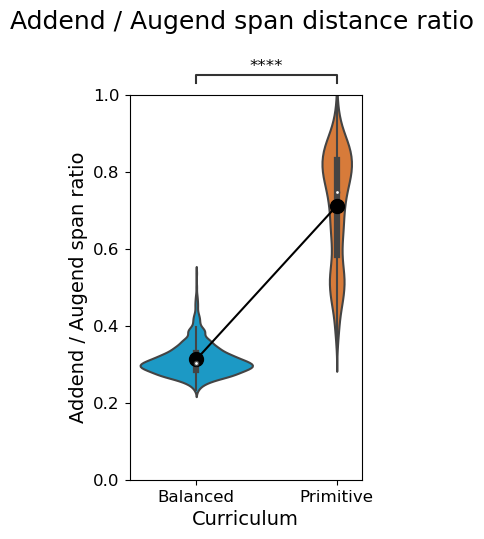

In [259]:
fig, ax = plt.subplots(figsize=(3,5))
sns.violinplot(data=df, x='Curriculum', y='Distance', palette=bp_pal, capsize=0.1, ax = ax)
mean_y = [np.mean(np.array(all_dists_b).flatten()),np.mean(np.array(all_dists_p).flatten())] 
ax.plot([0,1], mean_y, marker="o", markersize=10, color='black')
ax.set_ylabel('Addend / Augend span ratio')
ax.set_ylim(0,1)

plt.suptitle('Addend / Augend span distance ratio', y=1.05)

statannot.add_stat_annotation(
    ax=ax,
    data=df,
    x='Curriculum',
    y='Distance',
    box_pairs=[('Balanced','Primitive')],
    test="Wilcoxon",
    text_format="star",
    loc='outside')


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Using zero_method  wilcox
Balanced v.s. Primitive: Wilcoxon test (paired samples) with Bonferroni correction, P_val=0.000e+00 stat=3.800e+01
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Using zero_method  wilcox
Balanced v.s. Primitive: Wilcoxon test (paired samples) with Bonferroni correction, P_val=3.241e-09 stat=9.213e+04


(<AxesSubplot: xlabel='Lazy initialization'>,
 [<statannot.StatResult.StatResult at 0x7f9ac03967c0>])

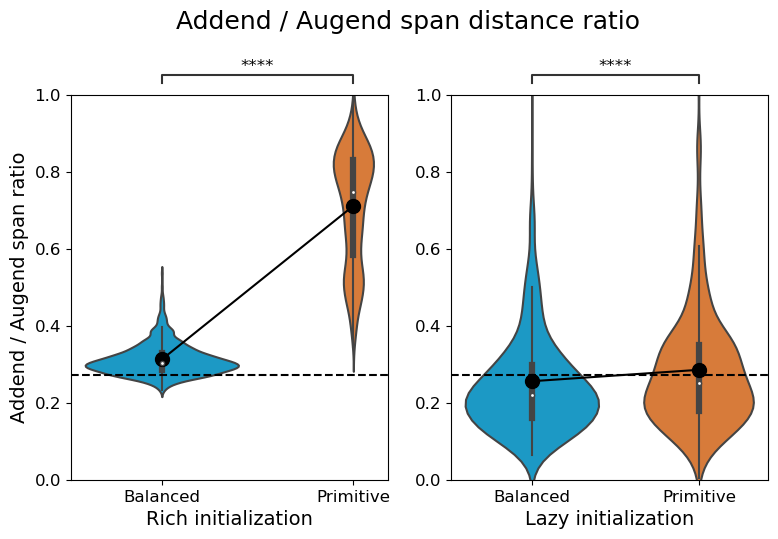

In [249]:
fig, ax = plt.subplots(1, 2, figsize=(9,5))
sns.violinplot(data=df, x='Regime', y='Distance', palette=bp_pal, capsize=0.1, ax = ax[0])
mean_y = [np.mean(np.array(all_dists_b).flatten()),np.mean(np.array(all_dists_p).flatten())] 
ax[0].plot([0,1], mean_y, marker="o", markersize=10, color='black')
ax[0].set_xlabel('Rich initialization')
ax[0].set_ylabel('Addend / Augend span ratio')

sns.violinplot(data=dfl, x='Regime', y='Distance', palette=bp_pal, capsize=0.1, ax = ax[1])
mean_y = [np.mean(np.array(all_dists_bl).flatten()),np.mean(np.array(all_dists_pl).flatten())] 
ax[1].plot([0,1], mean_y, marker="o", markersize=10, color='black')
ax[1].set_ylim(0,1.5)
ax[1].set_xlabel('Lazy initialization')
ax[1].set_ylim(0,1)
ax[1].set_ylabel('')
ax[0].set_ylim(0,1)
ax[0].axhline(y=np.mean(mean_y), linestyle = '--', color='black')
ax[1].axhline(y=np.mean(mean_y), linestyle = '--', color='black')

plt.suptitle('Addend / Augend span distance ratio', y=1.05)

statannot.add_stat_annotation(
    ax=ax[0],
    data=df,
    x='Regime',
    y='Distance',
    box_pairs=[('Balanced','Primitive')],
    test="Wilcoxon",
    text_format="star",
    loc='outside'
)

statannot.add_stat_annotation(
    ax=ax[1],
    data=dfl,
    x='Regime',
    y='Distance',
    box_pairs=[('Balanced','Primitive')],
    test="Wilcoxon",
    text_format="star",
    loc='outside'
)


# Visualise Lazy regime

In [207]:
matlist_pl = [np.array(d).mean(axis = 0) for d in dms_pl]

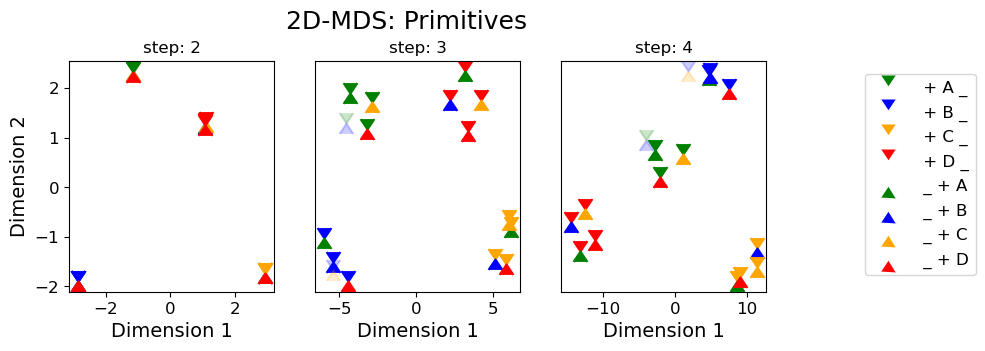

In [260]:
MDS_plot(matlist_pl, testseqs_all, trainseqs_p, title='Primitives', rand_state=x)

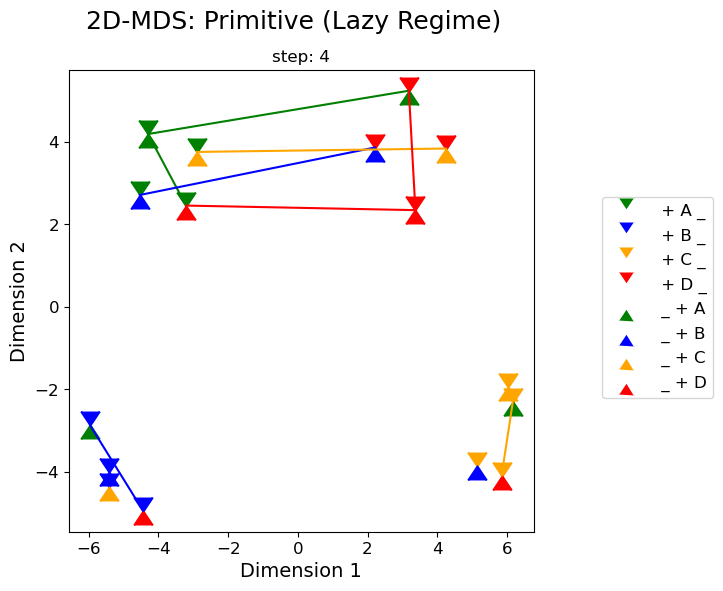

In [263]:
x=48
#MDS_plot_prims([matlist_p[2]], testseqs_all, rand_state=80, title='Primitives')
MDS_plot_prims([matlist_pl[2]], testseqs_all, title='Primitive (Lazy Regime)', rand_state=x, plotlines=True)